# Section 1 : Environnement

In [ ]:
import numpy as np

class BattleshipGame:
    def __init__(self, grid_size=5):
        self.grid_size = grid_size
        self.reset()

    def reset(self, initialize_ships=None):
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)    # 0: empty, 1: hit, 2: ship, -1: miss
        self.grid_visible = np.zeros((self.grid_size, self.grid_size), dtype=int)      # 0: empty, 1: hit, -1: miss   (for the player to see)
        self.number_of_hits = 0
        self.ships = []    # List of ships with their lengths, positions, directions, and states
        self.rdisc = 0     # reward discount
        if initialize_ships is None:
            self.initialize_ships_little()
        else:
            pos = initialize_ships
            if pos < self.grid_size*(self.grid_size-2):
                direction = 'H'
                col = pos // (self.grid_size-2)
                row = pos % (self.grid_size-2)
            else:
                direction = 'V'
                row = (pos - self.grid_size*(self.grid_size-2)) // (self.grid_size-2)
                col = (pos - self.grid_size*(self.grid_size-2)) % (self.grid_size-2)
            self.add_ship(3, (row, col), direction)

        self.legal_actions = [] # legal (empty) cells available for moves
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                self.legal_actions.append((i,j))    # this gets updated as an action is performed

        return self.grid_visible    # return the visible board

    def initialize_ships(self):
        ship_definitions = [(2, 1), (3, 1), (4, 1)]     # (length, quantity)
        self.total_hits = 9
        for length, quantity in ship_definitions:
            for _ in range(quantity):
                self.place_ship_randomly(length)

    def initialize_ships_little(self):
        ship_definitions = [(3,1)]     # (length, quantity)
        self.total_hits = 3
        for length, quantity in ship_definitions:
            for _ in range(quantity):
                self.place_ship_randomly(length)

    def display(self):
        symbols = {0: '🌊', 2: '🚢', 1: '💥', -1: '⚪'}

        header = " " + "   ".join(str(i).rjust(3) for i in range(self.grid_size))
        print(header)

        for y in range(self.grid_size):
            row_symbols = [symbols[self.grid[y, x]] for x in range(self.grid_size)]
            row_str = str(y).ljust(3) + ' ' + '   '.join(row_symbols)
            print(row_str)

    def display_visible(self):
        symbols = {0: '🌊', 2: '🚢', 1: '💥', -1: '⚪'}

        header = " " + "   ".join(str(i).rjust(3) for i in range(self.grid_size))
        print(header)

        for y in range(self.grid_size):
            row_symbols = [symbols[self.grid_visible[y, x]] for x in range(self.grid_size)]
            row_str = str(y).ljust(3) + ' ' + '   '.join(row_symbols)
            print(row_str)

    def step(self, action):
        i , j = np.unravel_index(action, (self.grid_size,self.grid_size))

        state = self.grid_visible.copy()

        empty_cnts_pre, hit_cnts_pre, miss_cnts_pre = self.board_config(state)    # board situation before action

        reward = 0
        if (i,j) not in self.legal_actions:
            keep_rndm = True
            while keep_rndm:
                action = np.random.randint(0,self.grid_size*self.grid_size)
                i, j = np.unravel_index(action, (self.grid_size,self.grid_size))
                if (i,j) in self.legal_actions:
                    keep_rndm = False
                reward -= 1 + (1-empty_cnts_pre)/(self.grid_size*self.grid_size)    # penalize for illegal move

        self.set_state(action)   # update the board with the action

        self.set_legal_actions((i,j))

        next_state = self.grid_visible

        empty_cnts_post, hit_cnts_post, miss_cnts_post = self.board_config(next_state)      # board situation after action

        done = bool(hit_cnts_post == self.total_hits)

        if hit_cnts_post-hit_cnts_pre==1: #hit
            r_discount = 0.5**self.rdisc
            reward += 10*r_discount*hit_cnts_post     # reward for a hit

        reward = float(reward)

        # after a hit, zero the discount, also don't start discounting if first hit hasn't happened yet
        if hit_cnts_post-hit_cnts_pre==1 or hit_cnts_pre==0:
            self.rdisc = 0
        else:
            # we discount the reward for a subsequent hit the longer it takes to score it
            self.rdisc += 1


        return next_state, reward, done

    def update_ships_status(self, action):
        x, y = action
        sunk = False
        for ship in self.ships:
            if not ship['sunk']:
                positions = self.calculate_ship_positions(ship)
                if (x, y) in positions:
                    ship['hits'] += 1
                    if ship['hits'] == ship['length']:
                        ship['sunk'] = True
                        sunk = True
                        break
        return sunk

    def calculate_ship_positions(self, ship):
        x, y = ship['position']
        positions = [(x+i, y) if ship['direction'] == 'H' else (x, y+i) for i in range(ship['length'])]
        return positions

    def check_all_sunk(self):
        return all(ship['sunk'] for ship in self.ships)

    def is_action_valid(self, action):
        x, y = action
        return self.grid[y, x] >= 0

    def place_ship_randomly(self, ship_length):
        placed = False
        while not placed:
            direction = 'H' if np.random.rand() > 0.5 else 'V'
            if direction == 'H':
                x = np.random.randint(0, self.grid_size - ship_length + 1)
                y = np.random.randint(0, self.grid_size)
            else:
                x = np.random.randint(0, self.grid_size)
                y = np.random.randint(0, self.grid_size - ship_length + 1)
            if self.check_free_space(ship_length, (x, y), direction):
                self.add_ship(ship_length, (x, y), direction)
                placed = True

    def check_free_space(self, ship_length, position, direction):
        x, y = position
        if direction.upper() == 'H':
            return all(self.grid[y, x+i] == 0 for i in range(ship_length))
        else:
            return all(self.grid[y+i, x] == 0 for i in range(ship_length))

    def add_ship(self, ship_length, position, direction):
        x, y = position
        if direction == 'H':
            self.grid[y, x:x+ship_length] = 2
        else:
            self.grid[y:y+ship_length, x] = 2
        self.ships.append({'length': ship_length, 'hits': 0, 'position': position, 'direction': direction, 'sunk': False})

    def board_config(self, state):
        uni_states, uni_cnts = np.unique(state.ravel(), return_counts=True)
        empty_cnts = uni_cnts[uni_states == 0]
        hit_cnts = uni_cnts[uni_states == 1]
        miss_cnts = uni_cnts[uni_states == -1]

        if len(empty_cnts)==0:
            empty_cnts = 0
        else:
            empty_cnts = empty_cnts[0]
        if len(hit_cnts)==0:
            hit_cnts = 0
        else:
            hit_cnts = hit_cnts[0]
        if len(miss_cnts)==0:
            miss_cnts = 0
        else:
            miss_cnts = miss_cnts[0]

        return empty_cnts, hit_cnts, miss_cnts

    def get_legal_actions(self):
        return self.legal_actions

    def set_legal_actions(self, action):
        if action in self.legal_actions:
            self.legal_actions.remove(action)

    def set_state(self, action):
        i , j = np.unravel_index(action, (self.grid_size,self.grid_size))
        if self.grid[i,j]==2:
            self.grid[i,j]= 1
            self.grid_visible[i,j] = 1
        else:
            self.grid[i,j]= -1
            self.grid_visible[i,j] = -1

    def play_episode(self, agent):
        self.reset()
        done = False
        reward = 0
        action = 0
        while not done:
            action = agent.choose_action(action, reward)
            self.number_of_hits += 1
            grid, reward, done = self.step(action)
        return self.number_of_hits

# Section 2 : Simple Agents

In [ ]:
# Agent that chooses random actions

class random_agent():
    def __init__(self, grid_size=5):
        self.grid_size = grid_size
    def choose_action(self, state, hit):
        return np.random.randint(0, self.grid_size**2)

In [ ]:
# Agent that searches for ships and then hunts them until they are sunk and then searches again

class search_and_hunt_agent():
    def __init__(self, grid_size=5):
        self.grid_size = grid_size
        self.is_hunting = False
        self.ship_hunted = []
        self.searched = []

    def choose_action(self, state, reward):
        if not self.is_hunting and reward >0:
            self.is_hunting = True
        if self.is_hunting:
            return self.hunt_ship(state, reward)
        else:
            return self.search_ship(state)

    def search_ship(self, state):
        action = np.random.randint(0, self.grid_size**2)
        while action in self.searched:
            action = np.random.randint(0, self.grid_size**2)
        self.searched.append(action)
        return action

    def hunt_ship(self, state, reward):
        if reward >0:
            self.ship_hunted.append(state)
        for state in self.ship_hunted:
            x, y = state % self.grid_size, state // self.grid_size
            if x > 0 and (state-1) not in self.searched:
                self.searched.append(state-1)
                return state-1
            elif x < self.grid_size-1 and (state+1) not in self.searched:
                self.searched.append(state+1)
                return state+1
            elif y > 0 and (state-self.grid_size) not in self.searched:
                self.searched.append(state-self.grid_size)
                return state-self.grid_size
            elif y < self.grid_size-1 and (state+self.grid_size) not in self.searched:
                self.searched.append(state+self.grid_size)
                return state+self.grid_size
        self.is_hunting = False
        return self.search_ship(state)

In [ ]:
env = BattleshipGame(5)
coup = 0
for i in range(1000):
    agent = search_and_hunt_agent(5)
    coup += env.play_episode(agent)

print(coup/1000)

10.251


# Section 3 : DeepQLearning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class Linear_t(nn.Module):
    def __init__(self, input_dim, n_action):
        super(Linear_t, self).__init__()
        self.fc = nn.Linear(input_dim, n_action)

    def forward(self, x):
        return self.fc(x)

In [ ]:
class MLP_t(nn.Module):
    def __init__(self, input_dim, n_action):
        super(MLP_t, self).__init__()
        self.fc = nn.Linear(input_dim, 124)
        self.fc2 = nn.Linear(124, n_action)

    def forward(self, x):
        x = self.fc2(torch.relu(self.fc(x)))
        return x

In [ ]:
class CNN_t(nn.Module):
    def __init__(self, input_dim, n_action):
        super(CNN_t, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, n_action)

    def forward(self, x):
        x = x.view(-1, 1, 5, 5)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze()
        return x

In [ ]:
class EpsilonGreedy:
    """
    An Epsilon-Greedy policy.

    Attributes
    ----------
    epsilon : float
        The initial probability of choosing a random action.
    epsilon_min : float
        The minimum probability of choosing a random action.
    epsilon_decay : float
        The decay rate for the epsilon value after each action.
    env : gym.Env
        The environment in which the agent is acting.
    q_network : torch.nn.Module
        The Q-Network used to estimate action values.

    Methods
    -------
    __call__(state: np.ndarray) -> np.int64
        Select an action for the given state using the epsilon-greedy policy.
    decay_epsilon()
        Decay the epsilon value after each action.
    """

    def __init__(self,
                 epsilon_start: float,
                 epsilon_min: float,
                 epsilon_decay:float,
                 env: BattleshipGame,
                 q_network: torch.nn.Module):
        """
        Initialize a new instance of EpsilonGreedy.

        Parameters
        ----------
        epsilon_start : float
            The initial probability of choosing a random action.
        epsilon_min : float
            The minimum probability of choosing a random action.
        epsilon_decay : float
            The decay rate for the epsilon value after each episode.
        env : gym.Env
            The environment in which the agent is acting.
        q_network : torch.nn.Module
            The Q-Network used to estimate action values.
        """
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.env = env
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:
        """
        Select an action for the given state using the epsilon-greedy policy.

        If a randomly chosen number is less than epsilon, a random action is chosen.
        Otherwise, the action with the highest estimated action value is chosen.

        Parameters
        ----------
        state : np.ndarray
            The current state of the environment.

        Returns
        -------
        np.int64
            The chosen action.
        """

        if np.random.uniform() <= self.epsilon:
            return np.random.randint(0,grid_size*grid_size)
        else:
            state_tensor = torch.from_numpy(state.astype(np.float32)).flatten()
            pred_values = self.q_network(state_tensor)
            return np.argmax(pred_values.cpu().detach().numpy())

    def decay_epsilon(self):
        """
        Decay the epsilon value after each episode.

        The new epsilon value is the maximum of `epsilon_min` and the product of the current
        epsilon value and `epsilon_decay`.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [ ]:
num_episodes = 50000

grid_size=5
gamma = 0.95
learning_rate=0.001
momentum=0.9
epsilon=1.0
epsilon_min=0.01
epsilon_decay=(epsilon_min/epsilon)**(1/(0.5*num_episodes))
episode_step = 0.005

env = BattleshipGame(grid_size=grid_size)
model = CNN_t(grid_size*grid_size, grid_size*grid_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
loss_fn = nn.MSELoss()
losses = []
epsilon_greedy = EpsilonGreedy(epsilon_start=epsilon, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, env=env, q_network=model)
reward_plot = []
epsilon_plot = []
losses_plot = []
counter_plot = []

t1 = 0

for t in range(num_episodes):

    obs = env.reset()
    if (t) % (episode_step*num_episodes) == 0:
        print('>>>>>>>>>>>>>>>>>>>Episode', t)
        if len(counter_plot)>0:
            print('Avg moves: ', np.mean(np.array(counter_plot).reshape(-1, int(episode_step*num_episodes))[t1]))
            print('Avg loss: ', np.mean(np.array(losses_plot).reshape(-1, int(episode_step*num_episodes))[t1]))
            t1 += 1

    if t==0:
        epsilon_plot = [0 for i in range(num_episodes)]
        counter_plot = [0 for i in range(num_episodes)]
        reward_plot = [0 for i in range(num_episodes)]
        losses_plot = [0 for i in range(num_episodes)]

    done  = False

    while not done:
        state = env.grid_visible.copy()
        action = epsilon_greedy(state)
        next_state, reward, done = env.step(action)

        state_tensor = torch.from_numpy(state.astype(np.float32)).flatten()
        action_tensor = torch.tensor(action)
        reward_tensor = torch.tensor(reward, dtype=torch.float32)
        next_state_tensor = torch.from_numpy(next_state.astype(np.float32)).flatten()

        with torch.no_grad():
            target = reward_tensor.clone()
            if not done:
                pred_values_next = model(next_state_tensor)
                target += gamma * torch.max(pred_values_next)

        pred_values = model(state_tensor)
        output = pred_values.clone()
        pred_values[action_tensor] = target
        optimizer.zero_grad()
        loss = loss_fn(output, pred_values)
        loss.backward()
        optimizer.step()

        losses_plot[t] += loss.item()

        counter_plot[t] += 1
        reward_plot[t] += reward
        epsilon_plot[t] = epsilon_greedy.epsilon

        if done:
            break

    epsilon_greedy.decay_epsilon()

>>>>>>>>>>>>>>>>>>>Episode 0
>>>>>>>>>>>>>>>>>>>Episode 250
Avg moves:  19.364
Avg loss:  21.444005611666398
>>>>>>>>>>>>>>>>>>>Episode 500
Avg moves:  19.232
Avg loss:  26.752483154536694
>>>>>>>>>>>>>>>>>>>Episode 750
Avg moves:  19.44
Avg loss:  22.36714046946797
>>>>>>>>>>>>>>>>>>>Episode 1000
Avg moves:  19.332
Avg loss:  18.662421765791006
>>>>>>>>>>>>>>>>>>>Episode 1250
Avg moves:  19.456
Avg loss:  23.480245423291013
>>>>>>>>>>>>>>>>>>>Episode 1500
Avg moves:  19.024
Avg loss:  20.289809259938583
>>>>>>>>>>>>>>>>>>>Episode 1750
Avg moves:  19.48
Avg loss:  18.12387832121819
>>>>>>>>>>>>>>>>>>>Episode 2000
Avg moves:  19.996
Avg loss:  20.831262956002103
>>>>>>>>>>>>>>>>>>>Episode 2250
Avg moves:  19.416
Avg loss:  19.41505405324942
>>>>>>>>>>>>>>>>>>>Episode 2500
Avg moves:  19.376
Avg loss:  19.801760590666245
>>>>>>>>>>>>>>>>>>>Episode 2750
Avg moves:  18.784
Avg loss:  17.49825891236976
>>>>>>>>>>>>>>>>>>>Episode 3000
Avg moves:  19.536
Avg loss:  22.58515742818088
>>>>>>>>>

KeyboardInterrupt: 

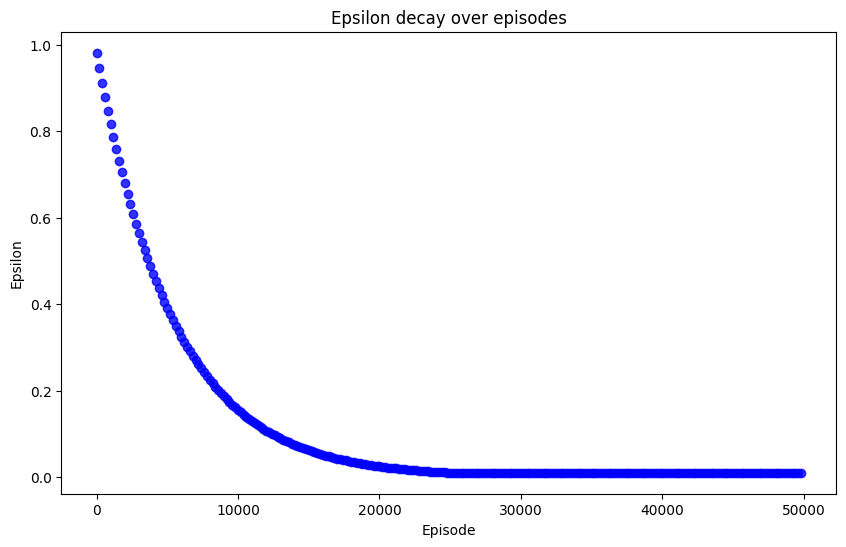

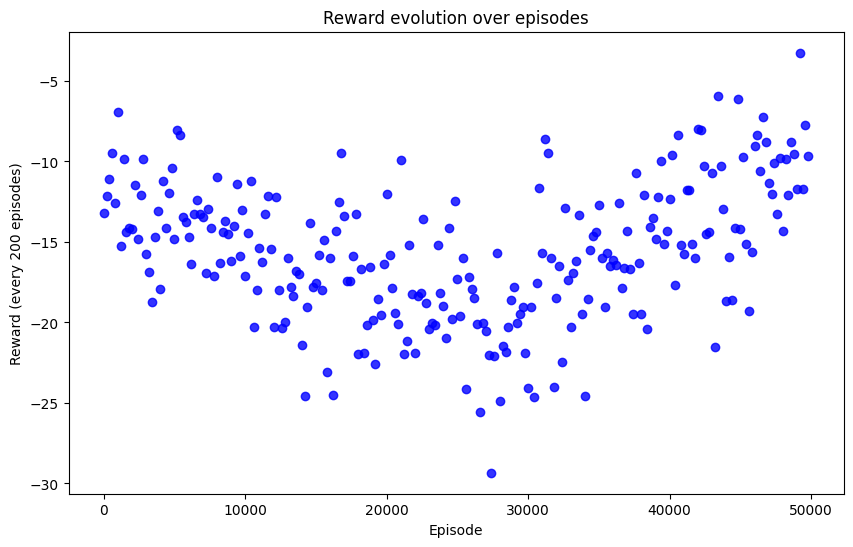

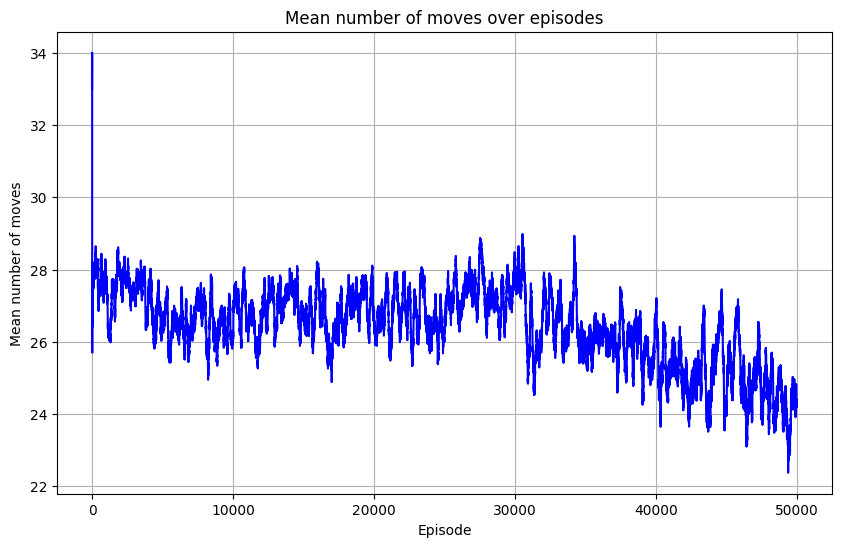

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_episode_step = 200

epsilon_plot_np = np.array(epsilon_plot)
losses_plot_np = np.array(losses_plot)
reward_plot_np = np.array(reward_plot)

episode_range = np.arange(0, num_episodes, num_episode_step)

plt.figure(figsize=(10, 6))
sns.regplot(x=episode_range, y=np.mean(epsilon_plot_np.reshape(-1, num_episode_step), axis=1), color="b", line_kws={'color':'green'}, fit_reg=False)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon decay over episodes')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(x=episode_range, y=np.mean(reward_plot_np.reshape(-1, num_episode_step), axis=1), color="b", lowess=True, line_kws={'color':'green'}, fit_reg=False)
plt.xlabel('Episode')
plt.ylabel('Reward (every {} episodes)'.format(num_episode_step))
plt.title('Reward evolution over episodes')
plt.show()

moving_avg_counter = [np.mean(counter_plot[max(0, i - num_episode_step):i + 1]) for i in range(len(counter_plot))]
plt.figure(figsize=(10, 6))
plt.plot(range(len(moving_avg_counter)), moving_avg_counter, color='b', linestyle='-')
plt.xlabel('Episode')
plt.ylabel('Mean number of moves')
plt.title('Mean number of moves over episodes')
plt.grid(True)
plt.show()


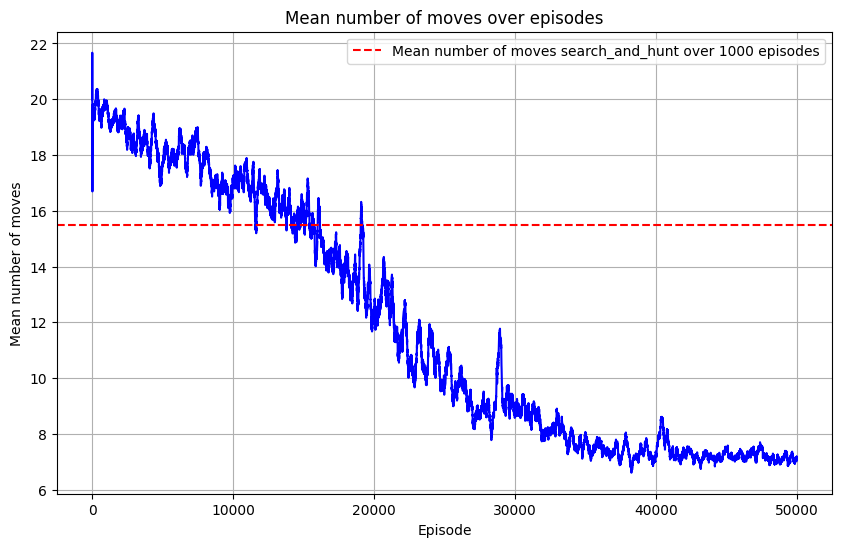

In [ ]:
avg_search_and_hunt = 10.174

moving_avg_counter = [np.mean(counter_plot[max(0, i - num_episode_step):i + 1]) for i in range(len(counter_plot))]
plt.figure(figsize=(10, 6))
plt.plot(range(len(moving_avg_counter)), moving_avg_counter, color='b', linestyle='-')
plt.axhline(y=avg_search_and_hunt, color='r', linestyle='--', label='Mean number of moves search_and_hunt over 1000 episodes')
plt.xlabel('Episode')
plt.ylabel('Mean number of moves')
plt.title('Mean number of moves over episodes')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'find_ship.pth')

In [ ]:
model_loaded = MLP_t(grid_size*grid_size, grid_size*grid_size)
model_loaded.load_state_dict(torch.load('find_ship.pth'))

<All keys matched successfully>

In [ ]:
num_episodes_test = 1000
grid_size=5
env = BattleshipGame(grid_size=grid_size)

mean_hits = 0
for t in range(num_episodes_test):
    obs = env.reset()
    done  = False
    number_of_hits = 0

    while not done:
        state = env.grid_visible.copy()

        state_tensor = torch.from_numpy(state.astype(np.float32)).flatten()
        pred_values = model_loaded(state_tensor)
        action = np.nanargmax(pred_values.detach().numpy())

        next_state, reward, done = env.step(action)

        number_of_hits += 1
        if done:
            break

    mean_hits += number_of_hits

#mean number of hits of our agents
print(mean_hits/num_episodes_test)

7.421


In [ ]:
num_episodes_test = 1
grid_size=5
env = BattleshipGame(grid_size=grid_size)

mean_hits = 0
for t in range(num_episodes_test):
    obs = env.reset()
    done  = False
    number_of_hits = 0

    while not done:
        state = env.grid_visible.copy()
        env.display()
        state_tensor = torch.from_numpy(state.astype(np.float32)).flatten()
        pred_values = model_loaded(state_tensor)
        action = np.nanargmax(pred_values.detach().numpy())

        next_state, reward, done = env.step(action)

        number_of_hits += 1
        if done:
            break

    mean_hits += number_of_hits

#example of a game
print(mean_hits/num_episodes_test)

   0     1     2     3     4
0   🌊   🌊   🌊   🌊   🌊
1   🌊   🌊   🌊   🌊   🌊
2   🌊   🌊   🌊   🌊   🚢
3   🌊   🌊   🌊   🌊   🚢
4   🌊   🌊   🌊   🌊   🚢
   0     1     2     3     4
0   🌊   🌊   🌊   🌊   🌊
1   🌊   🌊   🌊   🌊   🌊
2   🌊   🌊   ⚪   🌊   🚢
3   🌊   🌊   🌊   🌊   🚢
4   🌊   🌊   🌊   🌊   🚢
   0     1     2     3     4
0   🌊   🌊   🌊   🌊   🌊
1   🌊   🌊   🌊   ⚪   🌊
2   🌊   🌊   ⚪   🌊   🚢
3   🌊   🌊   🌊   🌊   🚢
4   🌊   🌊   🌊   🌊   🚢
   0     1     2     3     4
0   🌊   🌊   🌊   🌊   🌊
1   🌊   🌊   🌊   ⚪   🌊
2   🌊   🌊   ⚪   🌊   💥
3   🌊   🌊   🌊   🌊   🚢
4   🌊   🌊   🌊   🌊   🚢
   0     1     2     3     4
0   🌊   🌊   🌊   🌊   🌊
1   🌊   🌊   🌊   ⚪   ⚪
2   🌊   🌊   ⚪   🌊   💥
3   🌊   🌊   🌊   🌊   🚢
4   🌊   🌊   🌊   🌊   🚢
   0     1     2     3     4
0   🌊   🌊   🌊   🌊   🌊
1   🌊   🌊   🌊   ⚪   ⚪
2   🌊   🌊   ⚪   🌊   💥
3   🌊   🌊   🌊   🌊   🚢
4   🌊   🌊   🌊   🌊   💥
6.0


# Section 3 : Adversarial methods

In [ ]:
grid_size = 5
model_loaded = MLP_t(grid_size*grid_size, grid_size*grid_size)
model_loaded.load_state_dict(torch.load('find_ship.pth'))

<All keys matched successfully>

In [ ]:
# mean number of hits of our agent with a fixed position of the ship

def mean_hits_with_pos(num_episodes_test, pos, model, display=False):
    mean_hits = 0
    env = BattleshipGame(grid_size=5)
    for t in range(num_episodes_test):
        obs = env.reset(pos)
        done  = False
        number_of_hits = 0

        while not done:
            state = env.grid_visible.copy()
            if display:
                env.display()
            state_tensor = torch.from_numpy(state.astype(np.float32)).flatten()
            pred_values = model(state_tensor)
            action = np.nanargmax(pred_values.detach().numpy())

            next_state, reward, done = env.step(action)

            number_of_hits += 1
            if done:
                break

        mean_hits += number_of_hits

    return mean_hits/num_episodes_test

In [ ]:
for pos in range(30):
    print(pos, mean_hits_with_pos(40, pos, model_loaded))

0 7.0
1 6.0
2 7.0
3 11.0
4 4.0
5 5.0
6 4.0
7 3.0
8 6.0
9 10.0
10 9.0
11 10.0
12 8.0
13 8.0
14 7.0
15 11.0
16 10.0
17 12.0
18 9.0
19 8.0
20 9.0
21 5.0
22 4.0
23 5.0
24 6.0
25 5.0
26 11.0
27 11.775
28 5.0
29 6.0


In [ ]:
tab_mean_hits = [mean_hits_with_pos(100, pos, model_loaded) for pos in range(30)]

In [ ]:
# probability of choosing the initial position of the ship for the adverserial agent
# the idea is to choose the position that has the highest mean number of hits for our agent

tab_proba_adverserial = np.exp(tab_mean_hits)/np.sum(np.exp(tab_mean_hits))

In [ ]:
num_episodes = 50000

grid_size=5
gamma = 0.95
learning_rate=0.001
momentum=0.9
epsilon=1.0
epsilon_min=0.01
epsilon_decay=(epsilon_min/epsilon)**(1/(0.5*num_episodes))
episode_step = 0.005
params = model_loaded.state_dict()
model = MLP_t(grid_size*grid_size, grid_size*grid_size)
model.load_state_dict(params)

env = BattleshipGame(grid_size=grid_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
loss_fn = nn.MSELoss()
losses = []
epsilon_greedy = EpsilonGreedy(epsilon_start=epsilon, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay, env=env, q_network=model)
reward_plot = []
epsilon_plot = []
losses_plot = []
counter_plot = []

t1 = 0

for t in range(num_episodes):
    ship = np.random.choice(30, p=tab_proba_adverserial)    # adverserial agent chooses the position of the ship
    obs = env.reset(ship)
    if (t) % (episode_step*num_episodes) == 0:
        print('>>>>>>>>>>>>>>>>>>>Episode', t)
        if len(counter_plot)>0:
            print('Avg moves: ', np.mean(np.array(counter_plot).reshape(-1, int(episode_step*num_episodes))[t1]))
            print('Avg loss: ', np.mean(np.array(losses_plot).reshape(-1, int(episode_step*num_episodes))[t1]))
            t1 += 1

    if t==0:
        epsilon_plot = [0 for i in range(num_episodes)]
        counter_plot = [0 for i in range(num_episodes)]
        reward_plot = [0 for i in range(num_episodes)]
        losses_plot = [0 for i in range(num_episodes)]

    done  = False

    while not done:
        state = env.grid_visible.copy()
        action = epsilon_greedy(state)

        next_state, reward, done = env.step(action)

        state_tensor = torch.from_numpy(state.astype(np.float32)).flatten()
        action_tensor = torch.tensor(action)
        reward_tensor = torch.tensor(reward, dtype=torch.float32)
        next_state_tensor = torch.from_numpy(next_state.astype(np.float32)).flatten()

        with torch.no_grad():
            target = reward_tensor.clone()
            if not done:
                pred_values_next = model(next_state_tensor)
                target += gamma * torch.max(pred_values_next)

        pred_values = model(state_tensor)
        output = pred_values.clone()
        pred_values[action_tensor] = target
        optimizer.zero_grad()
        loss = loss_fn(output, pred_values)
        loss.backward()
        optimizer.step()

        losses_plot[t] += loss.item()

        counter_plot[t] += 1
        reward_plot[t] += reward
        epsilon_plot[t] = epsilon_greedy.epsilon

        if done:
            break

    epsilon_greedy.decay_epsilon()

>>>>>>>>>>>>>>>>>>>Episode 0
>>>>>>>>>>>>>>>>>>>Episode 250
Avg moves:  20.064
Avg loss:  139.81353332650536
>>>>>>>>>>>>>>>>>>>Episode 500
Avg moves:  18.856
Avg loss:  48.86875421193427
>>>>>>>>>>>>>>>>>>>Episode 750
Avg moves:  18.7
Avg loss:  40.83986498555439
>>>>>>>>>>>>>>>>>>>Episode 1000
Avg moves:  17.576
Avg loss:  29.17059532020438
>>>>>>>>>>>>>>>>>>>Episode 1250
Avg moves:  17.24
Avg loss:  23.852328850370164
>>>>>>>>>>>>>>>>>>>Episode 1500
Avg moves:  16.54
Avg loss:  23.795522777562176
>>>>>>>>>>>>>>>>>>>Episode 1750
Avg moves:  15.92
Avg loss:  20.634413472707035
>>>>>>>>>>>>>>>>>>>Episode 2000
Avg moves:  16.46
Avg loss:  22.288305621291148
>>>>>>>>>>>>>>>>>>>Episode 2250
Avg moves:  14.628
Avg loss:  17.795601627974268
>>>>>>>>>>>>>>>>>>>Episode 2500
Avg moves:  14.3
Avg loss:  20.396757514631492
>>>>>>>>>>>>>>>>>>>Episode 2750
Avg moves:  14.164
Avg loss:  17.758992830484107
>>>>>>>>>>>>>>>>>>>Episode 3000
Avg moves:  12.38
Avg loss:  20.110391924526308
>>>>>>>>>>>>>>

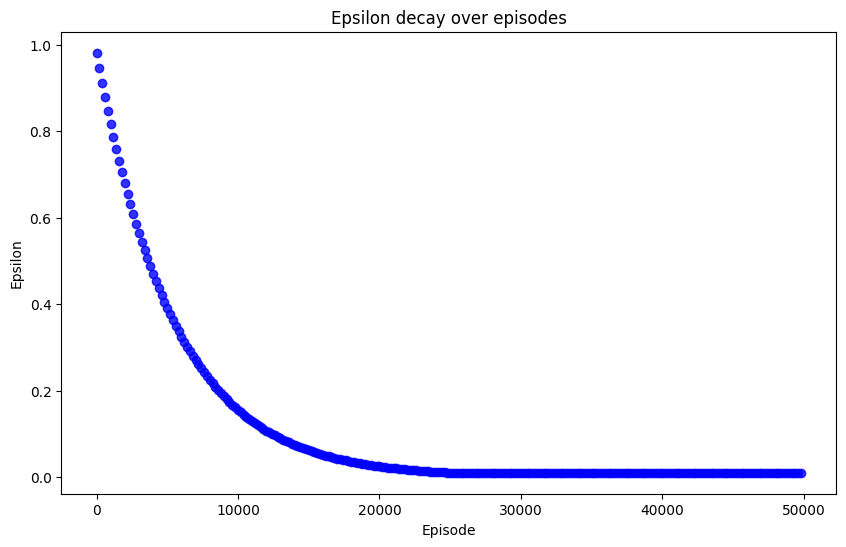

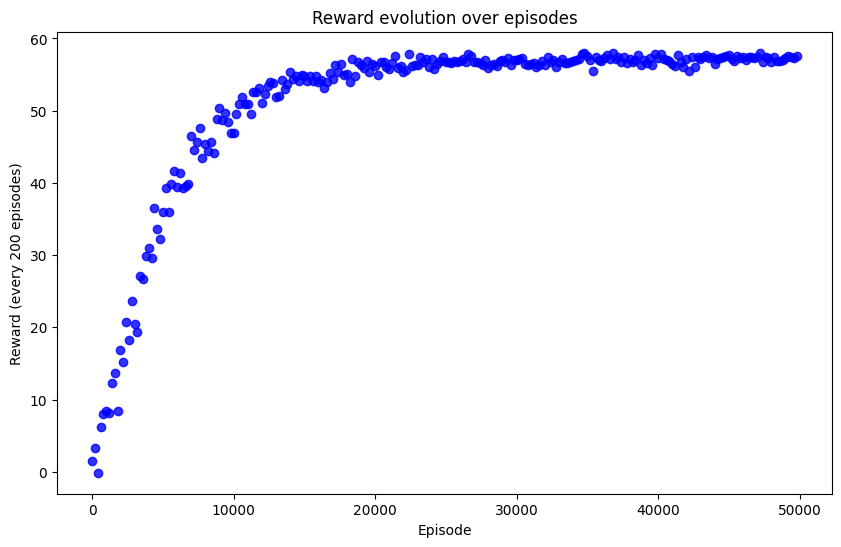

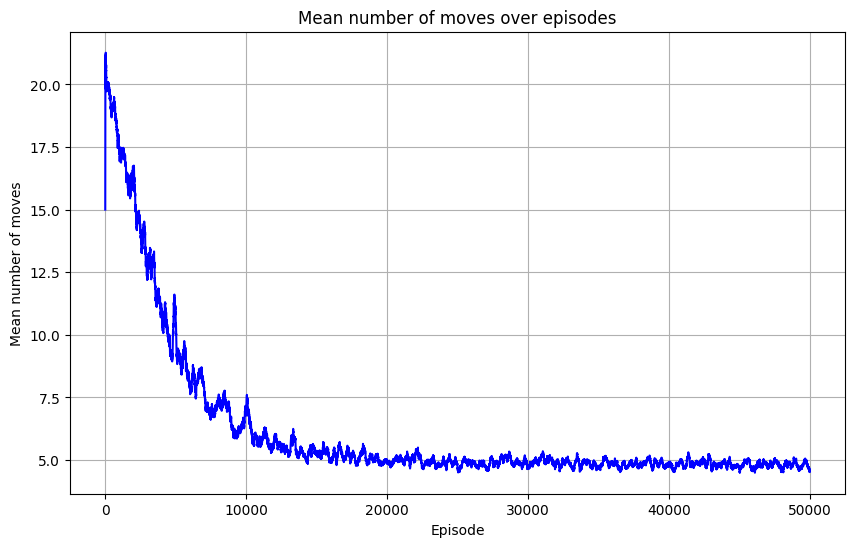

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_episode_step = 200

epsilon_plot_np = np.array(epsilon_plot)
losses_plot_np = np.array(losses_plot)
reward_plot_np = np.array(reward_plot)

episode_range = np.arange(0, num_episodes, num_episode_step)

plt.figure(figsize=(10, 6))
sns.regplot(x=episode_range, y=np.mean(epsilon_plot_np.reshape(-1, num_episode_step), axis=1), color="b", line_kws={'color':'green'}, fit_reg=False)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon decay over episodes')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(x=episode_range, y=np.mean(reward_plot_np.reshape(-1, num_episode_step), axis=1), color="b", lowess=True, line_kws={'color':'green'}, fit_reg=False)
plt.xlabel('Episode')
plt.ylabel('Reward (every {} episodes)'.format(num_episode_step))
plt.title('Reward evolution over episodes')
plt.show()

moving_avg_counter = [np.mean(counter_plot[max(0, i - num_episode_step):i + 1]) for i in range(len(counter_plot))]
plt.figure(figsize=(10, 6))
plt.plot(range(len(moving_avg_counter)), moving_avg_counter, color='b', linestyle='-')
plt.xlabel('Episode')
plt.ylabel('Mean number of moves')
plt.title('Mean number of moves over episodes')
plt.grid(True)
plt.show()


# Section 4 : self-play agent

In [ ]:
import numpy as np


class Agent_placement:
    """
    An agent for placing ships in a grid for a battleship game. The agent utilizes
    an epsilon-greedy strategy for action selection and updates its strategy based on
    the received rewards.

    Attributes
    ----------
    grid_size : int
        The size of the grid on which ships are placed.
    ship_list : list of tuples
        A list of tuples where each tuple represents a ship type and its count.
    epsilon : float
        The initial probability of choosing a random action.
    epsilon_decay : float
        The factor by which epsilon is decayed after each action.
    """

    def __init__(self, grid_size, ship_list, epsilon=0.9, epsilon_decay=0.99):
        """
        Initialize a new instance of placement ship
        """
        self.length_ships = [a for a, b in ship_list for _ in range(b)]
        length_q_values = [(grid_size - (length-1))*grid_size*2 for length in self.length_ships]
        self.q_values = np.empty(length_q_values)
        self.ship_list = ship_list
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.grid_size = grid_size
        self.reward = 0
        self.positions = []
        self.coord = []
        self.directions = []
        self.reset()

    def reset(self): #resets probabilities
        shape = np.shape(self.q_values)
        total_elements = 1
        for val in shape:
          total_elements *= val
        prob_uniforme = 1.0 / total_elements
        self.q_values = np.full(shape, prob_uniforme)

    def get_action(self):
        """
        Select an action for the given state using the epsilon-greedy policy.

        If a randomly chosen number is less than epsilon, a random action is chosen.
        Otherwise, the action with the highest estimated action value is chosen.

        Parameters
        ----------
        state : np.ndarray
            The current state of the environment.

        Returns
        -------
        np.int64
            The chosen action.
        """
        self.coord = []
        self.directions = []
        x = np.random.rand()
        self.positions = []
        if x < self.epsilon : #Get a random_action
          action,_,_,_ = self.choose_random_action()
          self.epsilon = self.epsilon * self.epsilon_decay
        else : #Compute the best action
            softmax_values = softmax(self.q_values)
            action_index = np.random.choice(range(len(softmax_values)), p=softmax_values)
            pos_ships = np.unravel_index(action_index, self.q_values.shape)
            action = self.place_ships(pos_ships)
            self.positions = pos_ships
        return action, self.coord, self.directions, self.length_ships

    def place_ships(self, pos_ships):
        """
        Places ships on the grid based on the given positions.

        Parameters
        ----------
        pos_ships : tuple
            The positions where ships are to be placed.

        Returns
        -------
        grid : np.ndarray
            The grid representation with ships placed according to pos_ships.
        """
        grid = np.zeros((self.grid_size,self.grid_size))
        for i in range(len(pos_ships)) :
          if len(pos_ships)>1:
            len_q = len(self.q_values[i])
          else :
            len_q = len(self.q_values)
          pos = pos_ships[i]
          if pos < ((self.grid_size - (self.length_ships[i]-1)) * (self.grid_size)): #Boat is placed horizontally (first 15 positions out of the 30 possible)
            self.directions.append("H")
            x = pos // (self.grid_size - (self.length_ships[i]-1))
            y = pos % (self.grid_size - (self.length_ships[i]-1))
            self.coord.append((x,y))
            for j in range(self.length_ships[i]):
              grid[x,y+j] += 2
          else : #Boat is placed vertically
            self.directions.append("V")
            npos = pos - ((self.grid_size - (self.length_ships[i]-1)) * (self.grid_size))
            x = (npos)//(self.grid_size)
            y = (npos)%(self.grid_size)
            self.coord.append((x,y))
            for j in range(self.length_ships[i]):
              grid[x+j,y] += 2
        return grid

    def choose_random_action(self):
        """
        Chooses a random action for placing ships on the grid.

        Returns
        -------
        grid : np.ndarray
            The grid representation with ships placed randomly.
        """
        self.coord = []
        self.directions = []
        grid = np.zeros((self.grid_size,self.grid_size))
        for ship in self.length_ships:
          self.place_ship_randomly(ship, grid)
        return grid, self.coord, self.directions, self.length_ships

    def place_ship_randomly(self, ship_length, grid):
        placed = False
        while not placed:
            direction = 'H' if np.random.rand() > 0.5 else 'V'
            if direction == 'H':
                x = np.random.randint(0, self.grid_size - ship_length + 1)
                y = np.random.randint(0, self.grid_size)
            else:
                x = np.random.randint(0, self.grid_size)
                y = np.random.randint(0, self.grid_size - ship_length + 1)
            if self.check_free_space(ship_length, (x, y), direction, grid):
                self.add_ship(ship_length, (x, y), direction, grid)
                self.directions.append(direction)
                self.coord.append((x,y))
                if direction == 'H': #Find the positions of the boats to update the q_value
                  self.positions.append(x*(self.grid_size - (ship_length-1)) + y)
                else :
                  self.positions.append((self.grid_size - (ship_length-1)) * (self.grid_size) + y* self.grid_size + x)
                placed = True

    def check_free_space(self, ship_length, position, direction, grid):
        x, y = position
        if direction.upper() == 'H':
            return all(grid[y, x+i] == 0 for i in range(ship_length))
        else:
            return all(grid[y+i, x] == 0 for i in range(ship_length))

    def add_ship(self, ship_length, position, direction, grid):
        x, y = position
        if direction == 'H':
            grid[y, x:x+ship_length] = 2
        else:
            grid[y:y+ship_length, x] = 2

    def recompute_prob(self, action, reward):
        """
        Recomputes the Q-values based on the received reward.

        Parameters
        ----------
        action : np.ndarray
            The last action taken by the agent.
        reward : float
            The reward received for the last action.
        """
        if reward <= 0:
          reward = 1/(self.grid_size*self.grid_size) #Smallest possible reward, big penalty
        indexes = tuple(self.positions)
        p = self.q_values[indexes]
        shape = self.q_values.shape
        prob_tous = (1-p**(reward))/(1-p) #Complementary function that allows you to have the sum of the probabilities at 1
        update_matrix = np.full(shape, prob_tous)
        self.q_values = self.q_values * update_matrix
        self.q_values[indexes] = p**(reward) # Function that does not exceed 1 and is not negative

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)
def get_reward(action, l ,pos, d):
    num_episodes_test = 100
    grid_size=5
    env = BattleshipGame(grid_size=grid_size)
    mean_hits1 = mean_hits_with_pos(100, pos, model)
    return mean_hits1

def train(epochs, grid_size = 5, ship_list = [(3,1)]):
    agent = Agent_placement(grid_size, ship_list)
    mean_reward = 5

    for epoch in range(epochs): #train
        reward = 0
        action,c,d,l = agent.get_action()
        new_action = action
        reward += get_reward(new_action,l,int(agent.positions[0]),d)
        reward = mean_reward/reward
        agent.recompute_prob(action, reward) #Recalculate probabilities based on previous action
    return agent

In [ ]:
a = train(100)

In [ ]:
print(a.q_values) #Represents the probability of placement in each case

[2.49504764e-03 8.53463381e-02 2.06757523e-05 5.17363886e-10
 1.68026720e-05 1.40167107e-01 2.10214072e-03 4.62615639e-01
 5.10026318e-04 3.85221573e-06 1.18210503e-06 2.32807675e-07
 5.17363886e-10 5.17363886e-10 5.83138247e-04 4.62235081e-16
 5.17363886e-10 5.17363886e-10 5.77274971e-04 8.67780572e-08
 2.87561792e-02 2.32008558e-02 5.17363886e-10 1.53813103e-01
 4.40809659e-03 3.56092058e-04 1.14153394e-06 3.08544696e-57
 9.50249844e-02 1.99362370e-18]


In [ ]:
import numpy as np


points1 = 1200
points2 = 1200

for placement in range(30):
  p1 = points1
  p2 = points2
  points1 += 20 * p2/p1
  points2 += -20 * p2/p1
print(points1)

1616.8248722939254


In [ ]:
#Elo System

points_1 = 1200
points_2 = 1200

def game(winner, points1, points2):
  if winner == 1 :
    p1 = points1
    p2 = points2
    points1 += 40 * p2/p1
    points2 += -40 * p2/p1
  else :
    p1 = points1
    p2 = points2
    points1 += -40 * p1/p2
    points2 += 40 * p1/p2

  return points1, points2